<a href="https://colab.research.google.com/github/Jugal-lachhwani/Kaggle-Notebooks/blob/main/Emergency_vehicles_classification_Using_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abhisheksinghblr_emergency_vehicles_identification_path = kagglehub.dataset_download('abhisheksinghblr/emergency-vehicles-identification')
jugallachhwani_imageofambulance_path = kagglehub.dataset_download('jugallachhwani/imageofambulance')

print('Data source import complete.')


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
import numpy as np
from tensorflow import keras
from tqdm import tqdm

# View Image

In [ ]:
image = cv2.imread("/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/100.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

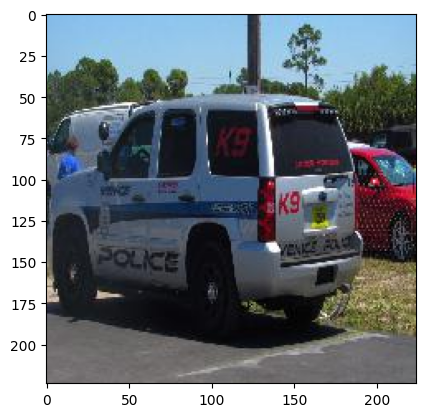

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(224, 224, 3)

# Image Preproccessing

In [ ]:
train_dir = '/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train'
test_dir = '/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test'

In [ ]:
image_gen_train = ImageDataGenerator(
    rotation_range=15,             # slight rotation (avoid distortion)
    width_shift_range=0.1,         # up to 10% horizontal shift
    height_shift_range=0.1,        # up to 10% vertical shift
    shear_range=0.1,               # mild shear for natural deformation
    zoom_range=0.1,                # slight zoom in/out      # small color shifts
    fill_mode='nearest',           # fill new pixels after shifting/rotating                   # constant fill value (used if fill_mode='constant')
    horizontal_flip=True,          # yes, often improves generalization
    vertical_flip=False,           # keep False unless vertical flips make sense (e.g., aerial images)
    rescale=1/255.0                # normalize pixel values to 0–1
)

image_gen_validate = ImageDataGenerator(          # keep False unless vertical flips make sense (e.g., aerial images)
    rescale=1/255.0                # normalize pixel values to 0–1
)

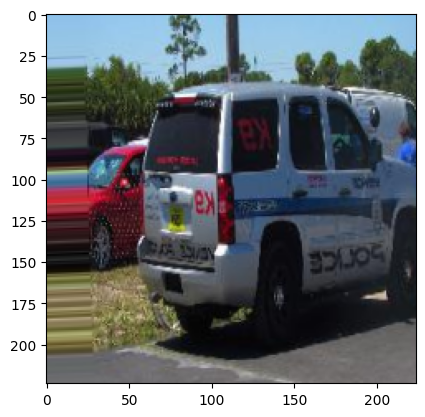

In [ ]:
plt.imshow(image_gen_train.random_transform(image))

In [ ]:
train_df = pd.read_csv('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train.csv')
test_df = pd.read_csv('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test.csv')

In [ ]:
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
test_df.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [ ]:
train_df['emergency_or_not'].value_counts()

emergency_or_not
0    965
1    681
Name: count, dtype: int64

In [ ]:
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [ ]:
train_generator=image_gen_train.flow_from_dataframe(dataframe=train_df[:1150], # specify the dataset used for trainin
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50,# defines the batch size
 shuffle = False
 )

validation_generator=image_gen_validate.flow_from_dataframe(dataframe=train_df[1150:], # specify the dataset used for tr
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50, # defines the batch size
shuffle=False
 )

Found 1150 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.


# Traning Model Using VGG19

In [ ]:
from tensorflow.keras.applications import VGG19,MobileNetV2,ResNet50
from tensorflow.keras.models import Model

In [ ]:
Vgg19_model = VGG19(weights = 'imagenet',include_top = False,input_shape = (224,224,3))

In [ ]:
Vgg19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Vgg19_model.trainable = True

### Training Last 2 Layers

In [ ]:
set_trainable = False

for layer in Vgg19_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable == False:
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
for layer in Vgg19_model.layers:
  print(layer.name,layer.trainable)

input_layer_12 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [ ]:
model1 = Sequential()
model1.add(Vgg19_model)
model1.add(Flatten())
model1.add(Dense(256,activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 24,121,857 (92.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [ ]:
model1.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='best_model_2.h5',       # file to save the best weights
    monitor='val_loss',             # metric to monitor (you can change to 'val_accuracy')
    save_best_only=True,            # only save when val_loss improves
    save_weights_only=False,        # save the full model (use True for only weights)
    mode='min',                     # 'min' for loss, 'max' for accuracy
    verbose=1
)

In [ ]:
history1 = model1.fit(train_generator,
                    epochs = 30,validation_data = validation_generator,callbacks=[checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6702 - loss: 0.6037
Epoch 1: val_loss improved from inf to 0.39092, saving model to best_model_2.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 957ms/step - accuracy: 0.6718 - loss: 0.6022 - val_accuracy: 0.8407 - val_loss: 0.3909
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8401 - loss: 0.3729
Epoch 2: val_loss improved from 0.39092 to 0.31033, saving model to best_model_2.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 822ms/step - accuracy: 0.8400 - loss: 0.3732 - val_accuracy: 0.8690 - val_loss: 0.3103
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8788 - loss: 0.3152
Epoch 3: val_loss improved from 0.31033 to 0.24303, saving model to best_model_2.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 805ms/step - accuracy: 0.8788 - loss: 0.3149 - val_accuracy: 0.9153 - val_loss: 0.2430
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8711 - loss: 0.2849
Epoch 4: val_loss improved from 0.24303 to 0.21350, sa

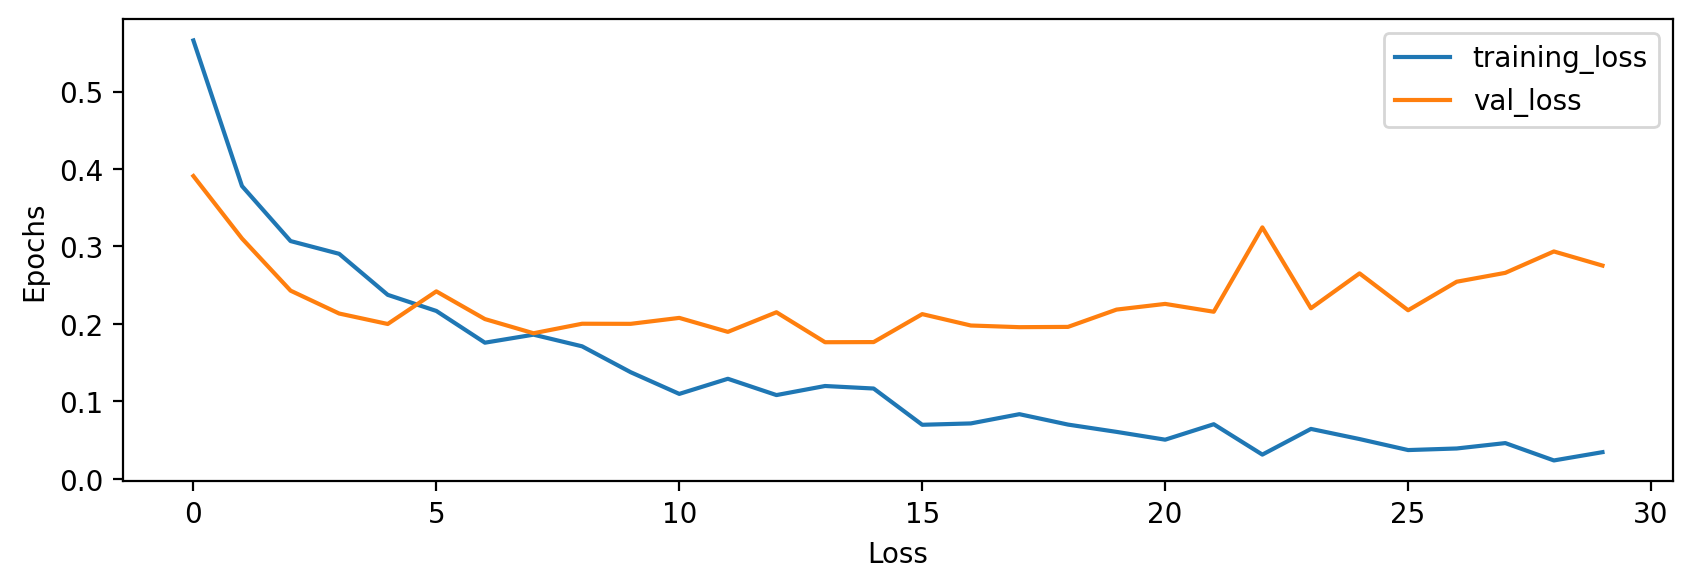

In [ ]:
## checking for overfitting
history_df = pd.DataFrame(history1.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],
 label='training_loss')
plt.plot(history_df['val_loss'],
 label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

### Saving Model

In [ ]:
best_model = load_model('/kaggle/working/best_model_2.h5')

### Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


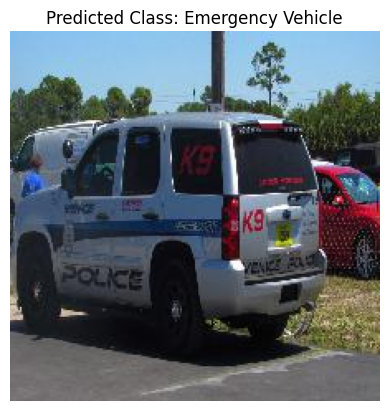

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = '/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/100.jpg'
img = Image.open(img_path).convert('RGB')
img = img.resize((224, 224))
img_array = np.array(img) / 255.0  # Normalize if your model was trained that way

# Add batch dimension: (1, 224, 224, 3)
img_input = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = best_model.predict(img_input)
# predicted_class = np.argmax(prediction)  # If output is softmax

if prediction[0] > 0.5:
    prediction_class = 'Emergency Vehicle'
else:
    prediction_class = 'Non Emergency Vehicle'

plt.imshow(img_array)
plt.axis('off')
plt.title(f"Predicted Class: {prediction_class}")
plt.show()


# Testing and Submitting

In [ ]:
test_df.index

RangeIndex(start=0, stop=706, step=1)

In [ ]:
test_dir_image = []
for i in tqdm(test_df.index):
    img_path = '/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/test/' + test_df['image_names'][i]  # Adjust the path to match the directory structure
    img = Image.open(img_path).convert('RGB')  # Load image using PIL
    img = img.resize((224, 224))  # Resize image
    img = np.array(img)  # Convert image to NumPy array
#     img = img / 255.0  # Normalize pixel values
    test_dir_image.append(img)


test = np.array(test_dir_image)

100%|██████████| 706/706 [00:08<00:00, 83.03it/s] 


In [ ]:
pred = best_model.predict(test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 431ms/step


In [ ]:
num_ = np.floor(pred)

In [ ]:
submission = pd.read_csv('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/sample_submission.csv')
submission['emergency_or_not'] = num_

In [ ]:
submission.to_csv('submission29.csv', index = False)

In [ ]:
submission.head(5)

,image_names,emergency_or_not
0,1960.jpg,0.0
1,668.jpg,1.0
2,2082.jpg,0.0
3,808.jpg,1.0
4,1907.jpg,0.0
